# Bootcamp Data Science Aplicada

# Módulo 05 - Machine Learning: Modelos, Métricas e Validação

Notebook para o acompanhamento das aulas e resoluções dos desafios propostos.

# Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# Aula 01 - Workflow de Machine Learning

Iniciamos a aula com uma parte mais conceitual explicando o ciclo de vida de um projeto de Machine Learning.

Agora vamos rever o que vimos na aula anterior sobre os dados de pacientes do Sírio Libanês.

In [2]:
data_url = 'https://github.com/diascarolina/data-science-bootcamp/blob/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'

dados = pd.read_excel(data_url)

In [3]:
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [4]:
def preenche_tabela(dados):
    '''
    Função que preenche os valores faltantes na tabela com o método 'bfill' e 'ffill'.
    Essa substituição é aplicada nas variáveis com dados contínuos.
    
    Entrada:
    dados -> um dataframe do pandas
    
    Saída:
    dados_finais -> um dataframe do pandas sem dados faltantes
    '''
    
    # seleciona as colunas com as variáveis que são contínuas
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    
    # pega os dados fornecidos e os armazenam no dataframe features_continuas
    # agrupa os dados por paciente, pega apenas as colunas com variáveis contínuas
    # e substitui os dados faltantes com os métodos 'bfill' e 'ffill'
    features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER',
                                       as_index = False)[features_continuas_colunas].fillna(method = 'bfill').fillna(method = 'ffill')
    
    # seleciona as colunas com as variáveis categóricas
    features_categoricas = dados.iloc[:, :13]
    # seleciona as colunas de saída
    saida = dados.iloc[:, -2:]
    # cria o dataframe 'dados_finais' concatenando os 3 dataframes criados acima
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index = True, axis = 1)
    # renomeia as colunas para o padrão original
    dados_finais.columns = dados.columns
    # retorna o dataframe criado
    return dados_finais

In [5]:
# utiliza a função acima para preencher os dados faltantes
dados_limpos = preenche_tabela(dados)

# faz uma query e pega apenas os pacientes com valor 'ICU = 1' na janela de tempo de 0 a 2 horas
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
# remove os pacientes que não satisfazem a condição acima
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
# remove os valores faltantes
dados_limpos = dados_limpos.dropna()
# mostra uma descrição estatística dos dados
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,...,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,...,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,97.750000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,191.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,289.250000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.764706,-0.738095,-0.919192,-0.726087,-0.651942,-0.771625,-0.756272,-0.736640,-0.920103,0.000000
max,384.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.329660,1.000000,1.000000


In [6]:
def prepare_window(rows):
    # se existir algum valor diferente de zero na coluna ICU
    if(np.any(rows['ICU'])):
        # pega a coluna WINDOW igual a 0-2 e a coluna ICU e coloca o valor 1 nelas
        rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1
    # retorna a coluna WINDOW igual a 0-2
    return rows.loc[rows['WINDOW'] == '0-2']

# agrupa o dataframe por paciente e aplica a função criada acima
dados_limpos = dados_limpos.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)

# transformar a coluna AGE_PERCENTIL em um dado do tipo category
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype('category').cat.codes

# mostra os início dos dados
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


In [7]:
# escolhe uma seed aleatória para manter sempre os mesmos resultados no código
np.random.seed(73246)

x_columns = dados.columns
y = dados_limpos['ICU']
# dropamos também a coluna WINDOW pois ela possue apenas um valor em todas as linhass, o valor 0-2
x = dados_limpos[x_columns].drop(['ICU','WINDOW'], axis = 1)

# divisão em dados de treino e dados de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y)

In [8]:
# inicialização do modelu Dummy
modelo_dummy = DummyClassifier()
# fit do modelo nos dados de treino
modelo_dummy.fit(x_train, y_train)

# previsão nos dados de teste
previsao_lr = modelo_dummy.predict(x_test)
# acurácia
print(f'A acurácia do modelo dummy foi de {accuracy_score(y_test, previsao_lr)}')

A acurácia do modelo dummy foi de 0.48863636363636365


/home/carolina/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [9]:
# inicializa o modelo de regressão logística
modelo_lr = LogisticRegression(max_iter = 5000)
# fit do modelo nos dados de treino
modelo_lr.fit(x_train, y_train)

# previsão nos dados de teste
previsao_lr = modelo_lr.predict(x_test)

print(f'A acurácia do modelo LogisticRegression foi de {accuracy_score(y_test, previsao_lr)}')

A acurácia do modelo LogisticRegression foi de 0.6818181818181818


## Desafios

**Desafio 01.** Transformar a coluna AGE_PERCENTIL em dados categóricos, mas utilizando outro método.
- [Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html) 

In [10]:
# dados_limpos = pd.get_dummies(dados_limpos, columns = ['AGE_PERCENTIL']).head()
# dados_limpos.head()

## O Que Aprendemos Nessa Aula
- Qual é um possível workflow em um projeto de Data Science;
- Realizar uma transformação de dados em dados categórigos;
- Aumentar o número de iterações da regressão logística para convergir.

# Aula 02 - Métricas de Avaliação

In [11]:
modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train, y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

0.6590909090909091

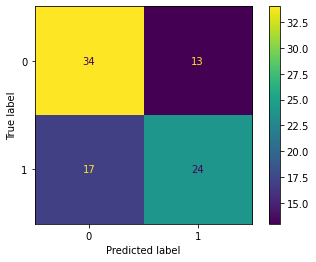

In [12]:
plot_confusion_matrix(modelo_arvore, x_test, y_test)

- **Verdadeiro Positivo** = 24
- **Verdadeiro Negativo** = 34
- **Falso Positivo** = 13
- **Falso Negativo** = 17

In [13]:
vp = 24
vn = 32
fp = 13
fn = 17

In [14]:
print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



- **Precisão:** todas as minhas classificações positivas, quantas são realmente positivas;
- **Recall:** de todas as classes positivas, quantas eu realmente classifiquei corretamente.

In [15]:
vp/(vp + fp)

0.6486486486486487

In [16]:
p = 1.0
r = 0.001
f1 = 2* (p * r)/(p + r)
f1

0.0019980019980019984

**Métrica AUC (Area Under Curve)**

In [17]:
# calcula a probabilidade da classe ser negativa e positiva
prob_arvore = modelo_arvore.predict_proba(x_test)
# calcula o auc score
# como a prob_arvore retorna duas colunas, pegamos apenas a que queremos, a probabilidade de ser positiva
roc_auc_score(y_test, prob_arvore[:,1])

0.6543850544888428

In [18]:
def roda_modelo(modelo, dados):
    
    x_columns = dados.columns
    y = dados['ICU']
    x = dados[x_columns].drop(['ICU', 'WINDOW'], axis = 1)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y)

    modelo.fit(x_train, y_train)
    predicao = modelo.predict(x_test)
    prob_predic = modelo.predict_proba(x_test)

    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC score: {auc}")
    print("\n------------------Classification Report------------------")
    print(classification_report(y_test, predicao))

In [19]:
roda_modelo(modelo_arvore, dados_limpos)

AUC score: 0.6193565127140633

------------------Classification Report------------------
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        47
           1       0.61      0.54      0.57        41

    accuracy                           0.62        88
   macro avg       0.62      0.62      0.62        88
weighted avg       0.62      0.62      0.62        88



In [20]:
roda_modelo(modelo_lr, dados_limpos)

AUC score: 0.7343020238713025

------------------Classification Report------------------
              precision    recall  f1-score   support

           0       0.64      0.81      0.72        47
           1       0.69      0.49      0.57        41

    accuracy                           0.66        88
   macro avg       0.67      0.65      0.64        88
weighted avg       0.67      0.66      0.65        88



## Desafios

**Desafio 02.** Verificar o impacto da mudança da categorização do _AGE_PERCENTIL_ dos resultados dos modelos.

Acurácia da regressão logística com a aplicação de um valor numérico inteiro para cada percentil de idade: 0.6818

In [21]:
# utiliza a função acima para preencher os dados faltantes
dados_limpos_2 = preenche_tabela(dados)

# faz uma query e pega apenas os pacientes com valor 'ICU = 1' na janela de tempo de 0 a 2 horas
a_remover = dados_limpos_2.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
# remove os pacientes que não satisfazem a condição acima
dados_limpos_2 = dados_limpos_2.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
# remove os valores faltantes
dados_limpos_2 = dados_limpos_2.dropna()
# mostra uma descrição estatística dos dados
dados_limpos_2.describe()

def prepare_window(rows):
    # se existir algum valor diferente de zero na coluna ICU
    if(np.any(rows['ICU'])):
        # pega a coluna WINDOW igual a 0-2 e a coluna ICU e coloca o valor 1 nelas
        rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1
    # retorna a coluna WINDOW igual a 0-2
    return rows.loc[rows['WINDOW'] == '0-2']

# agrupa o dataframe por paciente e aplica a função criada acima
dados_limpos_2 = dados_limpos_2.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)

# transformar a coluna AGE_PERCENTIL em um dado do tipo category
dados_limpos_2 = pd.get_dummies(dados_limpos_2, columns = ['AGE_PERCENTIL'])

# mostra os início dos dados
dados_limpos_2.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
# escolhe uma seed aleatória para manter sempre os mesmos resultados no código
np.random.seed(73246)

x_columns_2 = dados_limpos_2.columns
y_2 = dados_limpos_2['ICU']
# dropamos também a coluna WINDOW pois ela possue apenas um valor em todas as linhass, o valor 0-2
x_2 = dados_limpos_2[x_columns_2].drop(['ICU','WINDOW'], axis = 1)

# divisão em dados de treino e dados de teste
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, stratify = y_2)

In [24]:
# inicializa o modelo de regressão logística
modelo_lr_2 = LogisticRegression(max_iter = 5000)
# fit do modelo nos dados de treino
modelo_lr_2.fit(x_train_2, y_train_2)

# previsão nos dados de teste
previsao_lr_2 = modelo_lr_2.predict(x_test_2)

print(f'A acurácia do modelo LogisticRegression foi de {accuracy_score(y_test, previsao_lr_2)}')

A acurácia do modelo LogisticRegression foi de 0.6818181818181818


Aparentemente não houve diferença do resultado utilizando a regressão logística com os diferentes modos de categorização do percentil de idade. Esse modelo provavelmente trata igualmente os dois métodos.

**Desafio 03.** Pesquisar sobre F-score.

- [How to interpret F-measure values?](https://stats.stackexchange.com/questions/49226/how-to-interpret-f-measure-values)

**Desafio 04.** Pesquisar e plotar a árvore de decisão criada pelo modelo.

- [Understanding the decision tree structure - Scikit-Learn Documentation](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

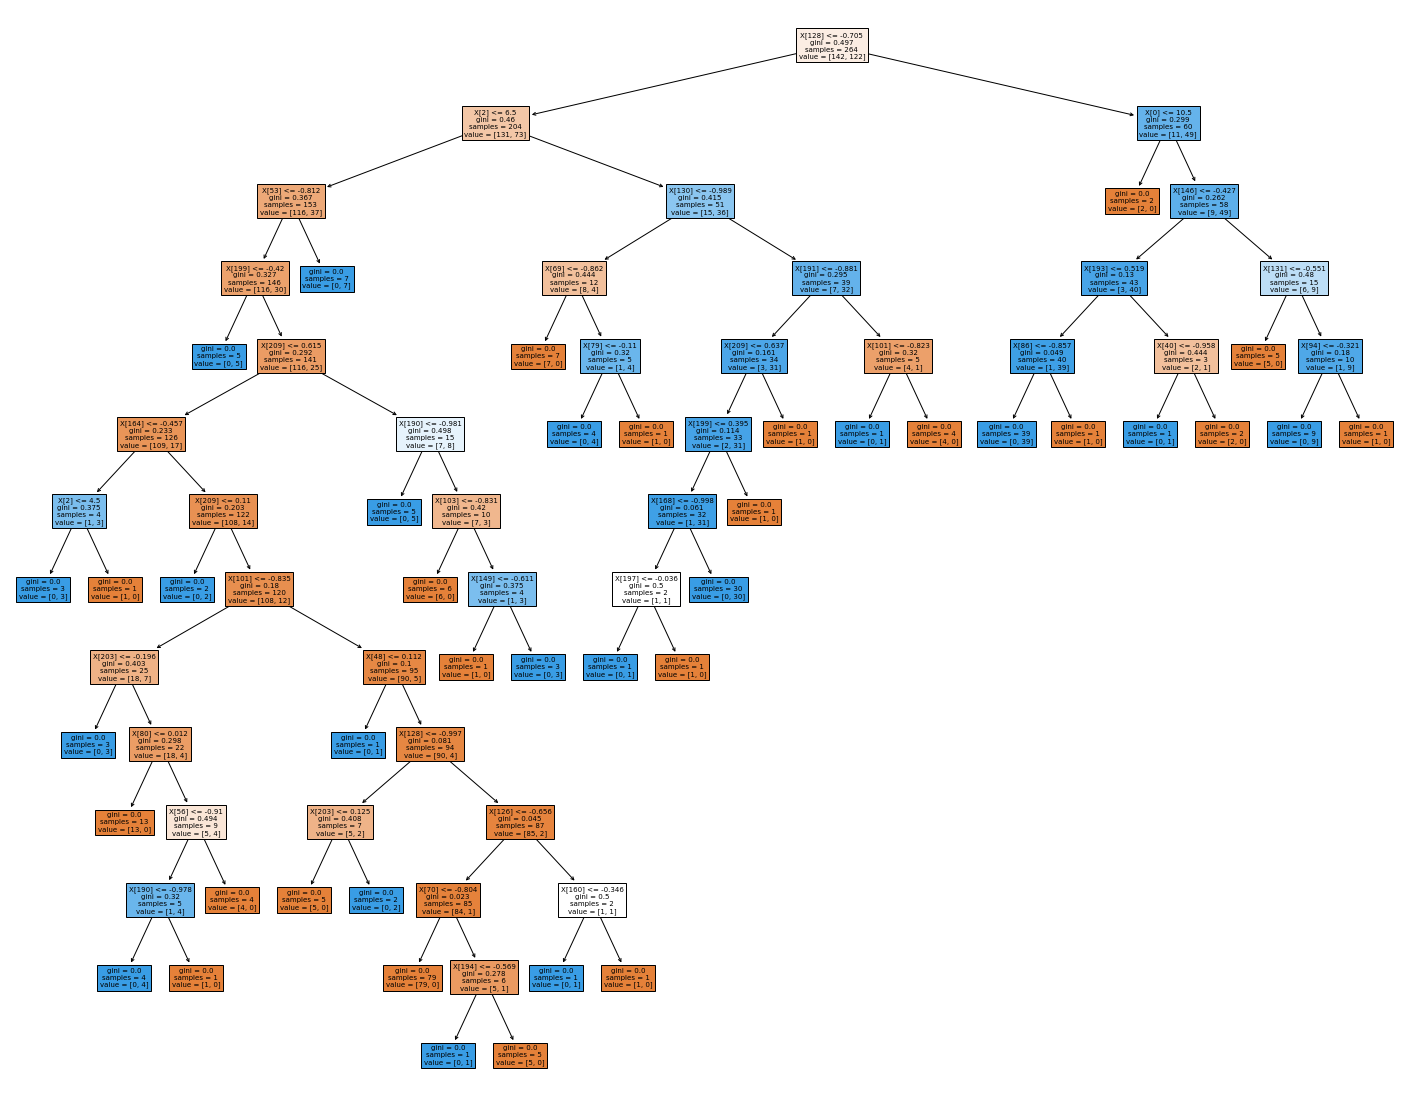

In [35]:
from sklearn import tree

fig = plt.figure(figsize = (25, 20))
tree.plot_tree(modelo_arvore, filled = True)
plt.show()

**Desafio 05.** Criar uma função que gere a cura ROC.

In [48]:
from sklearn.metrics import roc_curve, plot_roc_curve

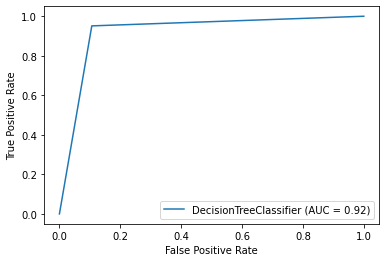

In [53]:
plot_roc_curve(modelo_arvore, x_test, y_test)

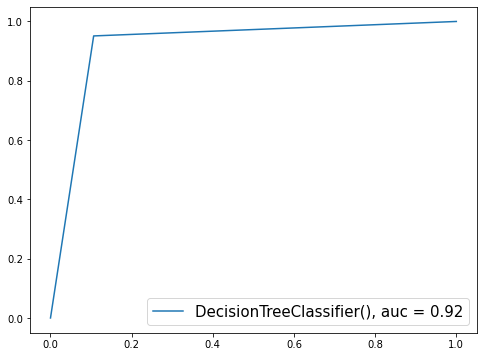

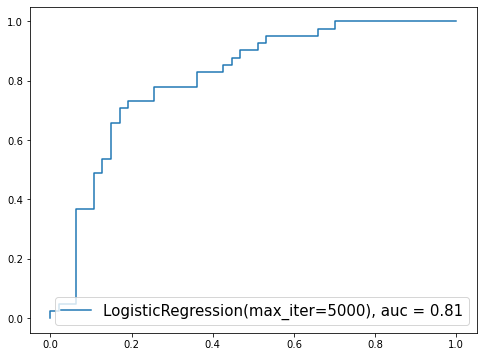

In [62]:
# helper: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
def gera_curva_roc(modelo):
    prob_predic = modelo.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, prob_predic[:,1])
    auc = roc_auc_score(y_test, prob_predic[:,1])
    fig = plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, label = f'{modelo}, auc = {round(auc, 2)}')
    plt.legend(loc = 4, fontsize = 15)
    plt.show()

gera_curva_roc(modelo_arvore)
gera_curva_roc(modelo_lr)

**Desafio 06.** Pensar e tentar diminuir o efeito da aleatoriedade nas previsões.

Pode-se setar um ```random_state``` diretamente no ```train_test_split()```.

## O Que Aprendemos Nessa Aula
- Como usar uma árvore de decisão;
- Analisar a qualidade dos resultados com a matriz de confusão;
- Gerar um relatório do resultado da classificação;
- O que é Recall, Precision, F-1 e AUC scores.

# Aula 03 - Aleatori